# Computer Modeling of Epidemics with the SIR Model

In this workbook we'll work through a simple model of how an epidemic spreads through a population. The model is called "SIR", because every individual in the population is assigned to one of three compartments:
\begin{align}
S &= \textrm{Susceptible} \\
I &= \textrm{Infected} \\
R &= \textrm{Removed (or Recovered)}
\end{align}

![susceptible -> infected -> removed](images/sir_flow.png)

The number of individuals in each "compartment" of the population changes as the epidemic spreads, according to a system of differential equations:

\begin{align}
\frac{dS}{dt} &= -\beta S(t) I(t) \\
\frac{dI}{dt} &= \beta S(t) I(t) - \gamma I(t) \\
\frac{dR}{dt} &= \gamma I(t)
\end{align}

Note that $\frac{dS}{dt} + \frac{dI}{dt} + \frac{dR}{dt} = 0$.

We can model the change in each compartment over time numerically by moving forward by time steps and updating each value (S,I,R) based on the corresponding differential equation.

As a brief aside, let's look at a numerical model for the motion of an object that is accelerating. The system of equations for the change in distance $x$ and velocity $dx$ are as follows:

\begin{align}
\frac{dx}{dt} &= v \\
\frac{dv}{dt} &= a & (\mathrm{or\ equivalently}\,\frac{d^2x}{dt^2})
\end{align}

Here is an example function to update distance and velocity according to the above equations. Note the update uses a midpoint formula based on half of the "old" velocity (the velocity at the beginning of the timestep) and half of the "new" velocity (the velocity at the end of the timestep).

In [78]:
function update(distance, velocity, acceleration, dt)
    new_v = velocity + acceleration * dt
    new_d = distance + 0.5(velocity * dt) + 0.5(new_v * dt)
    return new_d, new_v
end

update (generic function with 2 methods)

We can use this update function to simulate the motion in the $x$ direction of an object that accelerates from a standing start at 1 metre per second per second, for example, a bicycle rolling downhill along a street where the distance along the street is $x$.

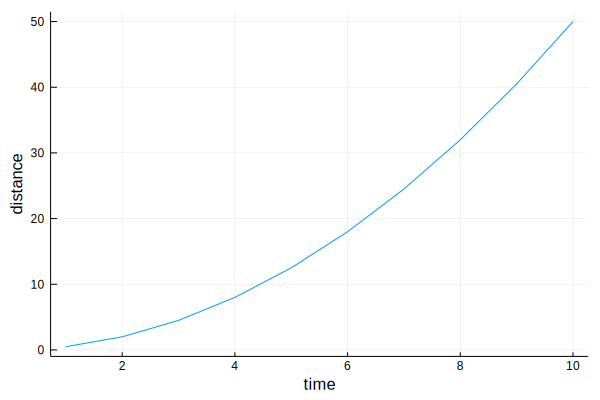

In [79]:
dt = 1.0 # time step is one second
nsteps = 10 # total time ten seconds
x = 0.0 # a distance of 0 from starting point
v = 0.0 # object is stationary at time t=0
a = 1.0 # accelerating at 1m/s^2

distance = Array{Float64}(undef, nsteps) # how far has the object travelled at each timestep?
for i = 1:nsteps
    x, v = update(x, v, a, dt)
    distance[i] = x
end

using Plots
plot(distance[1:nsteps], xlabel="time", ylabel="distance", legend=false)

Back to the SIR model: we can define an update function for the number of individuals in the three compartments, based on the model parameters beta and gamma:

In [80]:
function update_SIR(current, beta, gam, dt)
    s = current[1]
    i = current[2]
    r = current[3]
    new_s = s - (beta * s * i * dt)
    new_i = i + (beta * s * i * dt) - (gam * i * dt)
    new_r = r + (gam * i * dt)
    return [new_s, new_i, new_r]
end

update_SIR (generic function with 1 method)

Now, we can use this function to model the change in each group over time for an imaginary outbreak in a group of 100 people. Initially only one person is infected.

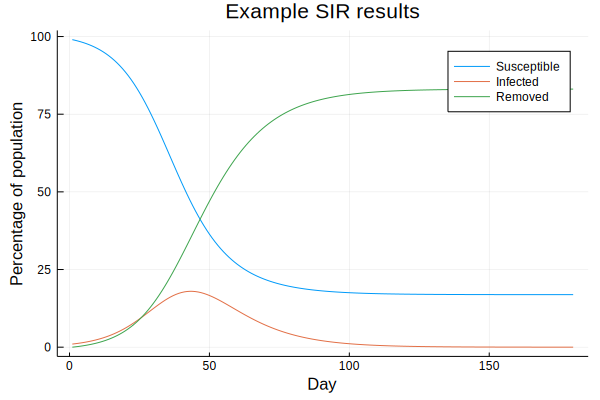

In [81]:
susceptible = 99
infectious = 1
removed = 0

num_days = 180
dt = 1.0 # timestep of one day
n_steps = round(Int64, num_days / dt)
result = Array{Float64}(undef, n_steps+1, 3)
time = 1:n_steps

beta = 0.0021 # probability of a infection
gam = 0.1 # 1/recovery time e.g. average 10 days to recover
result[1,:] = [susceptible, infectious, removed]
for step = 1:n_steps
    new = update_SIR(result[step,:], beta, gam, dt)
    result[step+1,1] = new[1]
    result[step+1,2] = new[2]
    result[step+1,3] = new[3]
end

using Plots
gr()
plot(time, result[1:n_steps,:], title="Example SIR results", xlabel="Day", ylabel="Percentage of population", labels = ["Susceptible" "Infected" "Removed"])

We can also look at real world data and see how well the actual progression of COVID-19 is simulated by the SIR model. The file [au_covid.csv](au_covid.csv) contains data for the first 72 days of the COVID-19 outbreak in Australia, taken from the first 72 days of the [2019 Novel Coronavirus COVID-19 (2019-nCoV) Data Repository by Johns Hopkins CSSE](https://github.com/CSSEGISandData/COVID-19/).

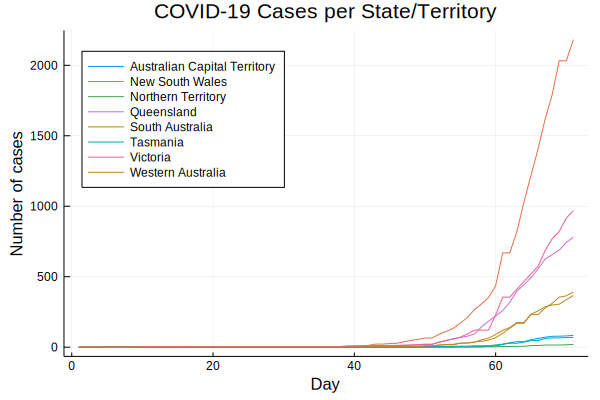

In [82]:
using CSV
x = CSV.read("au_covid.csv", transpose=true)
states = convert(Matrix, x)
state_names = reshape(String.(names(x)), 1, :)
plot(states, title="COVID-19 Cases per State/Territory", xlabel="Day", ylabel="Number of cases", labels=state_names, legend=:topleft)

We'll just look at the national total, as the numbers for each state are too small to accurately model.

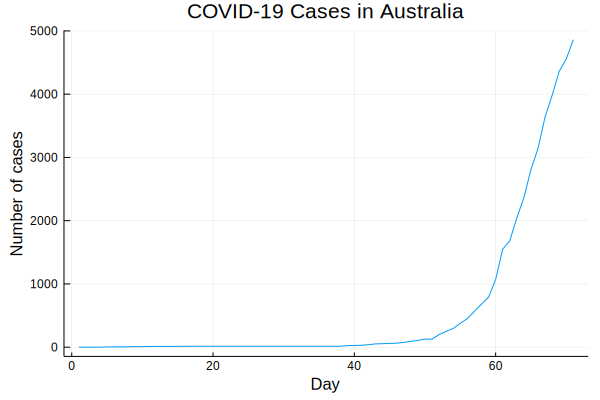

In [83]:
national=sum(states,dims=2)
plot(national,title="COVID-19 Cases in Australia", xlabel="Day", ylabel="Number of cases", legend=false)

For a population of the size of Australia, we can choose arbitrary values of beta and gamma to see how closely the SIR model matches the observed data. Try changing the values in the code below to see how it affects the fit.

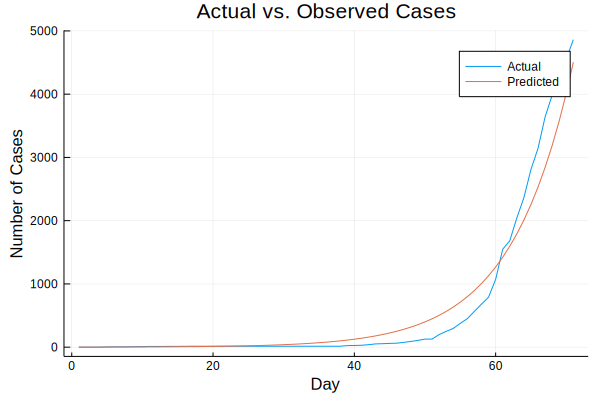

In [84]:
popsize=24600000
infected = 1
beta = 7e-9
gam = 0.05 # 20-day infectious period

num_days = size(states,1)
dt = 1.0 # timestep of one day
n_steps = round(Int64, num_days / dt)
result = Array{Float64}(undef, n_steps+1, 3)

time = 1:n_steps
result[1,1:3] = [popsize-infected,infected,0.0]
for step = time
    new = update_SIR(result[step,:], beta, gam, dt)
    result[step+1,1] = new[1]
    result[step+1,2] = new[2]
    result[step+1,3] = new[3]
end
predicted=result[1:n_steps,2]+result[1:n_steps,3]

plot(time, [national,predicted], title="Actual vs. Observed Cases", xlabel="Day", ylabel="Number of Cases", labels = ["Actual" "Predicted"])

Rather than guessing the values of $\beta$ and $\gamma$, it would be better to fit them to the data to minimize the mean squared error between the predicted and actual values for each day. The [DifferentialEquations.jl](https://docs.sciml.ai/v1.6/analysis/parameter_estimation.html) package allows us to perform this fitting in Julia - but that's a subject for a future notebook.